# Custom User-based Model
The present notebooks aims at creating a UserBased class that inherits from the Algobase class (surprise package) and that can be customized with various similarity metrics, peer groups and score aggregation functions. 

In [558]:
# reloads modules automatically before entering the execution of code
%load_ext autoreload
%autoreload 2

# standard library imports
# -- add new imports here --

# third parties imports
import numpy as np 
import pandas as pd
from surprise import AlgoBase
from surprise.prediction_algorithms import KNNWithMeans
from surprise import PredictionImpossible, Prediction

# -- add new imports here --
import matplotlib.pyplot as plt
import seaborn as sns
import heapq

# local imports
from constants import Constant as C
from loaders import load_ratings
# -- add new imports here --

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Loading Data
Prepare a dataset in order to help implementing a user-based recommender system

In [559]:
# -- load data, build trainset and anti testset --
df = load_ratings(surprise_format=True)

train = df.build_full_trainset()
print(train.global_mean)
test = train.build_anti_testset()

for i in test:
    print(i)

3.1333333333333333
(11, 1214, 3.1333333333333333)
(11, 364, 3.1333333333333333)
(11, 4308, 3.1333333333333333)
(11, 527, 3.1333333333333333)
(13, 1997, 3.1333333333333333)
(13, 4993, 3.1333333333333333)
(13, 2700, 3.1333333333333333)
(13, 1721, 3.1333333333333333)
(13, 527, 3.1333333333333333)
(17, 2028, 3.1333333333333333)
(17, 4993, 3.1333333333333333)
(17, 1214, 3.1333333333333333)
(17, 4308, 3.1333333333333333)
(19, 1997, 3.1333333333333333)
(19, 2028, 3.1333333333333333)
(19, 4993, 3.1333333333333333)
(19, 5952, 3.1333333333333333)
(19, 2700, 3.1333333333333333)
(19, 1721, 3.1333333333333333)
(19, 1214, 3.1333333333333333)
(19, 364, 3.1333333333333333)
(23, 1997, 3.1333333333333333)
(23, 2700, 3.1333333333333333)
(27, 1997, 3.1333333333333333)
(27, 2028, 3.1333333333333333)
(27, 5952, 3.1333333333333333)
(27, 2700, 3.1333333333333333)
(27, 1721, 3.1333333333333333)
(27, 364, 3.1333333333333333)
(27, 4308, 3.1333333333333333)


# 2. Explore Surprise's user-based algorithm
Displays user-based predictions and similarity matrix on the test dataset using the KNNWithMeans class

Computing the msd similarity matrix...
Done computing similarity matrix.
user: 11         item: 364        r_ui = None   est = 2.49   {'actual_k': 2, 'was_impossible': False}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd simi

,uid,iid,r_ui,est,details,k,min_k,min_support
0,11,1214,3.133333,2.500000,"{'actual_k': 1, 'was_impossible': False}",1,1,1
1,11,364,3.133333,3.104167,"{'actual_k': 1, 'was_impossible': False}",1,1,1
2,11,4308,3.133333,1.604167,"{'actual_k': 1, 'was_impossible': False}",1,1,1
3,11,527,3.133333,3.500000,"{'actual_k': 1, 'was_impossible': False}",1,1,1
4,13,1997,3.133333,1.133333,"{'actual_k': 1, 'was_impossible': False}",1,1,1
...,...,...,...,...,...,...,...,...
805,27,5952,3.133333,4.666667,"{'actual_k': 1, 'was_impossible': False}",3,3,3
806,27,2700,3.133333,4.666667,"{'actual_k': 0, 'was_impossible': False}",3,3,3
807,27,1721,3.133333,4.666667,"{'actual_k': 1, 'was_impossible': False}",3,3,3
808,27,364,3.133333,4.666667,"{'actual_k': 1, 'was_impossible': False}",3,3,3


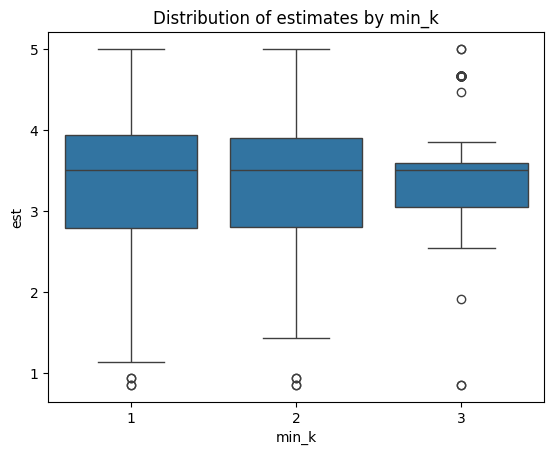

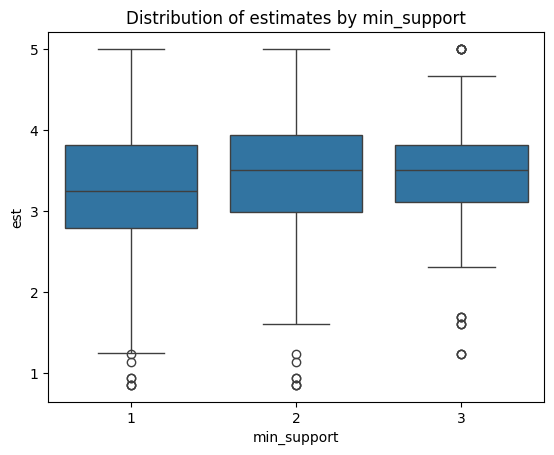

est          
           mean       std
min_k                    
1      3.346094  1.005528
2      3.452112  0.833347
3      3.490230  0.736468

est          
                 mean       std
min_support                    
1            3.329259  0.928073
2            3.472053  0.878301
3            3.487124  0.781772

'\nObservations :\n\nAs "min_k" increases, the standard deviation of the estimates decreases. This can be explained by\nthe relationship between "min_k" and "min_support" : the increase in "min_support" gives tighter\nconstrains to the algorithm, preventing it from finding a sufficient number of neighbors\n(observed when "actual_k" = 0) and thus mapping an estimate equal to the average of the distribution. \n\n'

In [ ]:
# -- using surprise's user-based algorithm, explore the impact of different parameters and displays predictions --
knn = KNNWithMeans(k = 3, sim_options={'user_based' : True, 'name' : 'MSD', 'min_support': 3})
knn.fit(train)
print(knn.predict(uid = 11, iid = 364))


allpred = []

for i in range(1, 4):
    for j in range(1, 4):
        for k in range(1, 4):
            knn = KNNWithMeans(k = i, min_k = j, sim_options={'user_based' : True, 'name' : 'MSD', 'min_support': k})
            knn.fit(train)
            pred = knn.test(test, verbose = False)
            pred_df = pd.DataFrame(pred)
            pred_df['k'] = i
            pred_df['min_k'] = j
            pred_df['min_support'] = k
            allpred.append(pred_df)

allpred_df = pd.concat(allpred, ignore_index=True)
display(allpred_df)

grouped_min_k = allpred_df.groupby(by=['min_k'])[['est']].agg(['mean', 'std'])
grouped_min_support = allpred_df.groupby(by=['min_support'])[['est']].agg(['mean', 'std'])

sns.boxplot(x='min_k', y='est', data=allpred_df)
plt.title('Distribution of estimates by min_k')
plt.xlabel('min_k')
plt.show()

sns.boxplot(x='min_support', y='est', data=allpred_df)
plt.title('Distribution of estimates by min_support')
plt.xlabel('min_support')
plt.show()

display(grouped_min_k)
display(grouped_min_support)

'''
Observations :

As "min_k" increases, the standard deviation of the estimates decreases. This can be explained by
the relationship between "min_k" and "min_support" : the increase in "min_support" gives tighter
constrains to the algorithm, preventing it from finding a sufficient number of neighbors
(observed when "actual_k" = 0) and thus mapping an estimate equal to the average of the distribution.

'''







# 3. Implement and explore a customizable user-based algorithm
Create a self-made user-based algorithm allowing to customize the similarity metric, peer group calculation and aggregation function

In [561]:
class UserBased(AlgoBase):
    def __init__(self, k=3, min_k=1, sim_options={}, **kwargs):
        AlgoBase.__init__(self, sim_options=sim_options, **kwargs)
        self.k = k
        self.min_k = min_k

        
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        # -- implement here the fit function --
        self.compute_rating_matrix()
        self.mean_ratings = np.nanmean(self.ratings_matrix, axis=1)
        self.compute_similarity_matrix()
        return self

    def test(self, testset):
        predictions = []
    
        for uid, iid, rat in testset:
            est = self.estimate(uid, iid)  
        
            predictions.append(Prediction(uid, iid, rat, est, {}))
    
        return predictions

    def estimate(self, u, i):
        trainset = self.trainset
        u = trainset.to_inner_uid(u)
        i = trainset.to_inner_iid(i)

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unknown.')
        
        estimate = self.mean_ratings[u]
        # -- implement here the estimate function --
        peergroup = []
        for (nb, rat) in self.trainset.ir[i] :
            if nb != u:
                sim = self.sim[u, nb]
                if sim > 0:
                    peergroup.append((nb, sim, rat))
        top_neighbours =  heapq.nlargest(self.k, peergroup, key=lambda x: x[1])

        num = 0
        denom = 0
        actual_k = 0

        for (nb, sim, rat) in top_neighbours:
            num += sim*(rat-np.nanmean(self.ratings_matrix[nb]))
            denom += sim
            actual_k += 1

        if actual_k >= self.min_k and denom != 0 :
            est = estimate + (num / denom)
            return est
        else :
            return estimate
                    
    def compute_rating_matrix(self):
        # -- implement here the compute_rating_matrix function --
        self.ratings_matrix = np.empty([self.trainset.n_users, self.trainset.n_items])
        self.ratings_matrix[:] = np.nan
        for uiid in self.trainset.ur:
            for iid, rating in self.trainset.ur[uiid]:
                self.ratings_matrix[uiid, iid] = rating
        return self.ratings_matrix
    
    def compute_similarity_matrix(self):
        # -- implement here the compute_rating_matrix function --
        self.sim = np.eye(self.trainset.n_users)
        for i in range(self.trainset.n_users):
            for j in range(i, self.trainset.n_users):
                # get common items
                common = ~np.isnan(self.ratings_matrix[i]) & ~np.isnan(self.ratings_matrix[j])
                if np.sum(common) >= self.sim_options['min_support']:
                    if self.sim_options['name'] == 'msd' :
                        diff = self.ratings_matrix[i][common] - self.ratings_matrix[j][common]
                        msd = np.mean(diff ** 2)
                        similarity = 1 / (1 + msd)
                    elif self.sim_options['name'] == 'jaccard':
                        union = np.count_nonzero(~np.isnan(self.ratings_matrix[i])) + np.count_nonzero(~np.isnan(self.ratings_matrix[j])) - np.count_nonzero(~np.isnan(self.ratings_matrix[i]) & ~np.isnan(self.ratings_matrix[j]))
                        similarity = np.sum(common) / union
                    
                    self.sim[i, j] = similarity
                    self.sim[j, i] = similarity
                
    
        return self.sim


#customizable 

# 4. Compare KNNWithMeans with UserBased
Try to replicate KNNWithMeans with your self-made UserBased and check that outcomes are identical

In [563]:
# -- assert that predictions are the same with different sim_options --


algo = UserBased(sim_options = {'min_support' : 3, 'name' : 'msd'}, min_k = 2) 
knn = KNNWithMeans(k = 3, sim_options={'user_based' : True, 'name' : 'MSD', 'min_support': 3}, min_k = 2)

knn.fit(train)
algo.fit(train)

print(test)
print('Predictions for our custom algorithm : ')
preds = algo.test(test)
print(preds)
print('Predictions for KNNWithMeans : ')
preds = knn.test(test)
print(preds)

print('Prediction (user 11, item 364) for our custom algorithm :')
print(algo.estimate(u = 11, i = 364))
print('Prediction (user 11, item 364) for KNNWithMeans :')
print(knn.predict(uid = 11, iid = 364))

print('Similarity matrix for our custom algorithm :')
print(algo.sim)
print('Similarity matrix for KNNWithMeans :')
print(knn.sim)

print('Mean ratings for our custom algorithm :')
print(algo.mean_ratings)
print('Mean ratings for KNNWithMeans :')
print(knn.means)


Computing the msd similarity matrix...
Done computing similarity matrix.
[(11, 1214, 3.1333333333333333), (11, 364, 3.1333333333333333), (11, 4308, 3.1333333333333333), (11, 527, 3.1333333333333333), (13, 1997, 3.1333333333333333), (13, 4993, 3.1333333333333333), (13, 2700, 3.1333333333333333), (13, 1721, 3.1333333333333333), (13, 527, 3.1333333333333333), (17, 2028, 3.1333333333333333), (17, 4993, 3.1333333333333333), (17, 1214, 3.1333333333333333), (17, 4308, 3.1333333333333333), (19, 1997, 3.1333333333333333), (19, 2028, 3.1333333333333333), (19, 4993, 3.1333333333333333), (19, 5952, 3.1333333333333333), (19, 2700, 3.1333333333333333), (19, 1721, 3.1333333333333333), (19, 1214, 3.1333333333333333), (19, 364, 3.1333333333333333), (23, 1997, 3.1333333333333333), (23, 2700, 3.1333333333333333), (27, 1997, 3.1333333333333333), (27, 2028, 3.1333333333333333), (27, 5952, 3.1333333333333333), (27, 2700, 3.1333333333333333), (27, 1721, 3.1333333333333333), (27, 364, 3.1333333333333333), (27

# 5. Compare MSD and Jacard
Compare predictions made with MSD similarity and Jacard similarity


In [ ]:
# -- compare predictions made with MSD similarity and Jacard similarity --
preds = []

algo = UserBased(sim_options = {'min_support' : 3, 'name' : 'jaccard'}, min_k = 2) 
algo.fit(train)
pred_jac = pd.DataFrame(algo.test(test))
pred_jac['sim_metric'] = 'jaccard'
preds.append(pred_jac)

algo = UserBased(sim_options = {'min_support' : 3, 'name' : 'msd'}, min_k = 2) 
algo.fit(train)
pred_msd = pd.DataFrame(algo.test(test))
pred_msd['sim_metric'] = 'msd'
preds.append(pred_msd)

preds_df = pd.concat(preds)

grouped = preds_df.groupby(by=['sim_metric'])[['est']].agg(['mean', 'std'])
display(grouped)



Predictions with Jaccard similarity
Predictions with MSD


est          
                mean       std
sim_metric                    
jaccard     3.568364  0.776374
msd         3.565473  0.735819